# Estimation du prix et analyse sur la distance et le prix des trajets en train SNCF

## 1. Installations des librairies

In [2]:
!pip install pyspark
!pip install geopy
!pip install python-Levenshtein

## 2. Import des librairies

In [3]:
import re
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, lit
from pyspark.sql.types import StructType, StructField, StringType, FloatType
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
from geopy import Point
from geopy.distance import geodesic, lonlat
from decimal import Decimal
from difflib import SequenceMatcher
import Levenshtein

In [4]:
# create SparkSession
spark = SparkSession.builder.master("local[*]") \
                    .appName('SparkSNCF') \
                    .getOrCreate()

# extract SparkContext
sc = spark.sparkContext

print('Spark is ready with CPU usage :', sc.defaultParallelism)

Spark is ready with CPU usage : 12


## 3. Import des données

Two datasets:
- Tarifs TGV par trajet SNCF
- Gares de voyageurs SNCF

In [7]:
# Load the data set
df_gare_prix_sql = spark.read.option("delimiter", ";").option("header",True).csv("./data/tarifs-tgv-par-od.csv")
df_gare_loc_sql = spark.read.option("delimiter", ";").option("header",True).csv("./data/referentiel-gares-voyageurs.csv")

## 4. Nettoyage des données

In [8]:
df_gare_loc_sql = df_gare_loc_sql.withColumn('Intitulé gare', regexp_replace('Intitulé gare', "'", " "))

In [9]:
noms_gare_originals = [
    'AIX-LES-BAINS - LE REVARD', 
    'VITRY-LE-FRANÇOIS', 
    'BELFORT-MONTBELIARD TGV', 
    'ST AVRE - LA CHAMBRE', 
    'BESANCON FRANCHE-COMTE TGV']

In [10]:
def remove_hyphen(df, noms_gare):
    if noms_gare:
        df = df.withColumn('OD', regexp_replace('OD', noms_gare[0], re.sub('\s*-\s*', ' ', noms_gare[0])))
        return remove_hyphen(df, noms_gare[1:])
    return df

In [11]:
remove_hyphen(df_gare_prix_sql, noms_gare_originals).createOrReplaceTempView("sncf_tgv")

In [12]:
df_tgv_1er = spark.sql(
    "SELECT \
    TRIM(SPLIT(OD, '-')[0]) AS Origine, \
    TRIM(SPLIT(OD, '-')[1]) AS Destination, \
    ROUND(TRIM(`1ère classe`), 2) AS Prix_1er, \
    ROUND(TRIM(`Plein Tarif Loisir 2nde`), 2) AS Prix_2eme \
    FROM sncf_tgv \
    WHERE Commentaires IS NULL OR Commentaires NOT LIKE '%jusqu%'")

In [13]:
df_tgv_1er.select('Origine', 'Destination').exceptAll(df_tgv_1er.select('Origine', 'Destination').dropDuplicates()).collect()

[]

- créer une fonction itineraryPrice(station1=`'Origine'`, station2=`'Destination'`) qui estimera le prix du trajet en 1ère classe entre les 2 noms de gares passés en paramètres
- cette fonction devra utiliser PySpark pour exploiter les datasets choisis

## 5. Estimation du prix

In [14]:
def itineraryPrice(origine, destination):
    try:
        origine = origine.strip().upper()
        destination = destination.strip().upper()
        itinerary = df_tgv_1er.where(f"(Origine = '{origine}' and Destination = '{destination}' or Origine = '{destination}' and Destination = '{origine}')")
        price = 0
        it_collect = itinerary.collect()
        for it in it_collect :
            price += it.Prix_1er

        return round(price / len(it_collect), 2)
    except Exception as e:
        return None


- lister 4 résultats d'appels de cette fonction avec des gares différentes pour chaque appel

In [15]:
print(itineraryPrice("tours", "chatellerault"))

23.5


In [16]:
print(itineraryPrice("BELFORT MONTBELIARD TGV", "paris gare de lyon"))

126.0


In [17]:
print(itineraryPrice("BESANCON FRANCHE COMTE TGV", "albertville"))

89.0


In [18]:
print(itineraryPrice("PARIS GARE DE LYON", "THONON LES BAINS"))

152.0


- la fonction devra retourner None dans le cas où :
  - les gares passées en paramètre n'existent pas 
  - le prix pour le trajet est inexistant


In [19]:
print(itineraryPrice("LES AUBRAIS ORLEANS", "BABYLON"))

None


In [20]:
print(itineraryPrice("Trifouilly les oies", "LILLE FLANDRES"))

None


In [21]:
print(itineraryPrice("Chartres", "paris gare de lyon"))

None


## 6. Analyse des données

2. Etablissez à l'aide du module python geopy un classement descendant des distances pour chaque trajets possible
- transformer les gares en coordonnées, calculer la distance grâce à geopy et utiliser la fonction


In [22]:
df_gare_loc_sql.createOrReplaceTempView("sncf_tgv_loc")
df_gare_loc = spark.sql("SELECT `Intitulé gare`, UT, RG, Latitude, Longitude FROM sncf_tgv_loc")

In [23]:
def similarTest(a, b):
    print(a,b)
    input_words = [i for i in [a[0], a[1], a[2]] if i]
    #Levenshtein
    similarity_list = [Levenshtein.ratio(s,b.title()) for s in input_words]
    return max(similarity_list)

In [24]:
def changeStructure(iterator):
    final_iterator = []
    for x in iterator:
        final_iterator.append((x[0], x[4], x[5], similarTest([x[1], x[2], x[3]], x[0])))   
    return iter(final_iterator)

def convertToPairwiseRD(iterator):
    final_iterator = []
    for x in iterator:
        final_iterator.append((x[0], x))   
    return iter(final_iterator)

In [25]:
df_tgv_1er.createOrReplaceTempView("SNCF_tgv_gares")
df_tgv_gares = spark.sql("(SELECT Origine AS gare_name FROM SNCF_tgv_gares) UNION (SELECT Destination AS gare_name FROM SNCF_tgv_gares)")
df_tgv_gares = df_tgv_gares.join(df_gare_loc)
df_tgv_gares = df_tgv_gares.repartition(5)
df_tgv_gares = df_tgv_gares.rdd.mapPartitions(changeStructure)
columns_name = ["gare_name","Latitude","Longitude","similarity"]
print(f"Split in {df_tgv_gares.getNumPartitions()} partitions")

df_tgv_gares = (df_tgv_gares
  .mapPartitions(convertToPairwiseRD)  # Convert to PairwiseRD
  # Take maximum of the passed arguments by the last element (key)
  # equivalent to:
  # lambda x, y: x if x[-1] > y[-1] else y
  .reduceByKey(lambda x1, x2: max(x1, x2, key=lambda x: x[-1])) 
  .values()) # Drop keys

df_tgv_gares.collect()
df_tgv_gares = df_tgv_gares.toDF(columns_name)


Split in 5 partitions


In [26]:
print(df_tgv_gares.count())
df_tgv_gares.show(5)

330
+------------------+----------+----------+------------------+
|         gare_name|  Latitude| Longitude|        similarity|
+------------------+----------+----------+------------------+
|LA BAULE ESCOUBLAC| 47.288690| -2.389102|0.9444444444444444|
|           morlaix| 48.577970| -3.832514|               1.0|
|        BAR LE DUC| 48.773308|  5.166822|               0.7|
|  THONON LES BAINS| 46.369004|  6.481669|            0.8125|
|         PORNICHET|47.2705354|-2.3445765|               1.0|
+------------------+----------+----------+------------------+
only showing top 5 rows



In [27]:
df_gare_loc.show(5)

+--------------------+--------------------+--------------------+----------+---------+
|       Intitulé gare|                  UT|                  RG|  Latitude|Longitude|
+--------------------+--------------------+--------------------+----------+---------+
| Lycée Henri Sellier|LIVRY GARGAN GARE...|GARES B IDF LIGNE T4|  48.91646|  2.51504|
|          Bena Fanes|ENVEITG HALTE DE ...|GARES C LANGUEDOC...|42.4580782|1.9167264|
|        Fontpédrouse|FONTPEDROUSE ST T...|GARES C LANGUEDOC...|42.5138062|2.1886585|
|                Nyer|          NYERS GARE|GARES C LANGUEDOC...|42.5416979|2.2630177|
|Prades - Molitg-l...|PRADES MOLITG LES...|GARES C LANGUEDOC...|42.6170988|2.4294184|
+--------------------+--------------------+--------------------+----------+---------+
only showing top 5 rows



In [28]:
df_tgv_1er.show(5)

+--------------+--------------------+--------+---------+
|       Origine|         Destination|Prix_1er|Prix_2eme|
+--------------+--------------------+--------+---------+
|LILLE FLANDRES|                AGDE|   188.0|    150.0|
|         ARRAS|                SETE|   188.0|    150.0|
|     PERPIGNAN|  TGV HAUTE PICARDIE|   188.0|    150.0|
|    DOLE VILLE|PARIS MONTPARNASS...|   106.0|     76.0|
|        COLMAR|         MACON VILLE|    90.0|     72.0|
+--------------+--------------------+--------+---------+
only showing top 5 rows



In [29]:
df_tgv_1er.createOrReplaceTempView("df_tgv_1er")
df_tgv_gares.createOrReplaceTempView("df_tgv_gares")
df_tgv_coords_od = spark.sql("\
SELECT\
  p.Origine,\
  p.Destination, \
  p.Prix_1er, \
  p.Prix_2eme, \
  p.Origine_Latitude, \
  p.Origine_Longitude, \
  g.Latitude AS Destination_Latitude, \
  g.Longitude AS Destination_Longitude \
from \
  (\
  SELECT \
      p.Origine, \
      p.Destination, \
      p.Prix_1er, \
      p.Prix_2eme, \
      g.Latitude AS Origine_Latitude, \
      g.Longitude AS Origine_Longitude \
  from df_tgv_1er p, \
    df_tgv_gares g \
  WHERE \
    p.Origine == g.gare_name\
    ) p, \
  df_tgv_gares g \
WHERE \
  p.Destination == g.gare_name")

df_tgv_coords_od.show(10)

+-------------------+---------------+--------+---------+----------------+-----------------+--------------------+---------------------+
|            Origine|    Destination|Prix_1er|Prix_2eme|Origine_Latitude|Origine_Longitude|Destination_Latitude|Destination_Longitude|
+-------------------+---------------+--------+---------+----------------+-----------------+--------------------+---------------------+
|        AVIGNON TGV|    CARCASSONNE|    69.0|     54.0|       43.921586|         4.786079|           43.218029|             2.351824|
|        DIJON VILLE|    CARCASSONNE|   141.0|    107.0|       49.353931|         6.169543|           43.218029|             2.351824|
|            AVIGNON|    CARCASSONNE|    69.0|     54.0|        50.40723|          2.83365|           43.218029|             2.351824|
|               AGEN|    CARCASSONNE|    54.0|     37.0|       44.208311|         0.620932|           43.218029|             2.351824|
|   BORDEAUX ST JEAN|    CARCASSONNE|    81.0|     53.0

In [30]:
def get_distance(tr) :
    try:
        geocode_or = (float(tr[4]), float(tr[5]))
        geocode_dest = (float(tr[6]), float(tr[7]))
        distance = geopy.distance.distance(lonlat(*geocode_or), lonlat(*geocode_dest)).km
        return (tr[0], tr[1], tr[2], tr[3], distance)
    except Exception as e:
       print(e)
       return None

In [31]:
geolocator = Nominatim(user_agent="SparkSNCF")
df_tgv_coords_od = df_tgv_coords_od.rdd.map(get_distance)
df_tgv_coords_od.take(2)

[('AVIGNON TGV', 'CARCASSONNE', 69.0, 54.0, 280.2955736153092),
 ('DIJON VILLE', 'CARCASSONNE', 141.0, 107.0, 801.2750435903873)]

In [32]:
df_tgv_coords_od_sample = df_tgv_coords_od.sample(False,0.1,1)

columns_name = ["Origine", "Destination","Prix_1er","Prix_2eme", "Distance"]
df_tgv_coords_od_sample = df_tgv_coords_od_sample.toDF(columns_name)
df_tgv_coords_od_sample = df_tgv_coords_od_sample.toPandas()

<AxesSubplot:xlabel='Distance', ylabel='Prix_1er'>

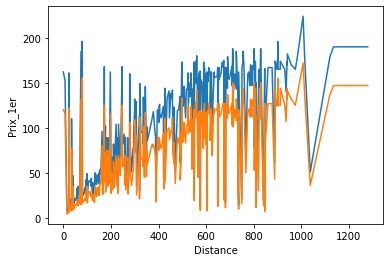

In [33]:
sns.lineplot(x="Distance", y="Prix_1er",
             data=df_tgv_coords_od_sample)
sns.lineplot(x="Distance", y="Prix_2eme",
             data=df_tgv_coords_od_sample)

In [34]:
df_tgv_coords_od_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Origine      391 non-null    object 
 1   Destination  391 non-null    object 
 2   Prix_1er     391 non-null    float64
 3   Prix_2eme    391 non-null    float64
 4   Distance     391 non-null    float64
dtypes: float64(3), object(2)
memory usage: 15.4+ KB
